In [1]:
import cv2
import os
import random
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.color import rgb2gray

In [2]:
def normalize_image(image):
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = rgb2gray(image)
  return (image - np.min(image)) / (np.max(image) - np.min(image))

In [9]:
def process_folder(folder_path, output_path=None):
  for filename in os.listdir(folder_path):
    if filename.endswith("png"):
      image_path = os.path.join(folder_path, filename)
      image = cv2.imread(image_path)
      normalized_image = normalize_image(image)
      if output_path:
        save_path = os.path.join(output_path, filename)
        cv2.imwrite(save_path, normalized_image * 255)
      else:
        cv2.imwrite(image_path, normalized_image * 255)

In [10]:
data_path = "../Datasets/NIST Special Database 302/SD 302a/challengers/A/roll/png"
output_path = '../Datasets/NIST Special Database 302/SD 302a/challengers/A/roll/Normalised_Images/Real'

In [11]:
os.makedirs(output_path, exist_ok=True)
process_folder(data_path, output_path)

In [12]:
os.makedirs("Generated_Images_NIST_Special_Dataset", exist_ok=True)

In [13]:
SEED = 1234
random.seed(SEED)
torch.manual_seed(SEED)

In [14]:
dataroot = "../Datasets/NIST Special Database 302/SD 302a/challengers/A/roll/Normalised_Images"
batch_size = 128
image_size = 64
nc = 3
nz = 100
ngf = 64
ndf = 64
num_epochs = 100
lr = 0.0002
beta1 = 0.5
real_label = 1
generated_label = 0

In [15]:
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [16]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh(),
        )

    def forward(self, inp):
        return self.main(inp)

In [17]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, inp):
        return self.main(inp)

In [18]:
dataset = dset.ImageFolder(root=dataroot,
    transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
shuffle=True, num_workers=2)

In [19]:
device = torch.device("mps")

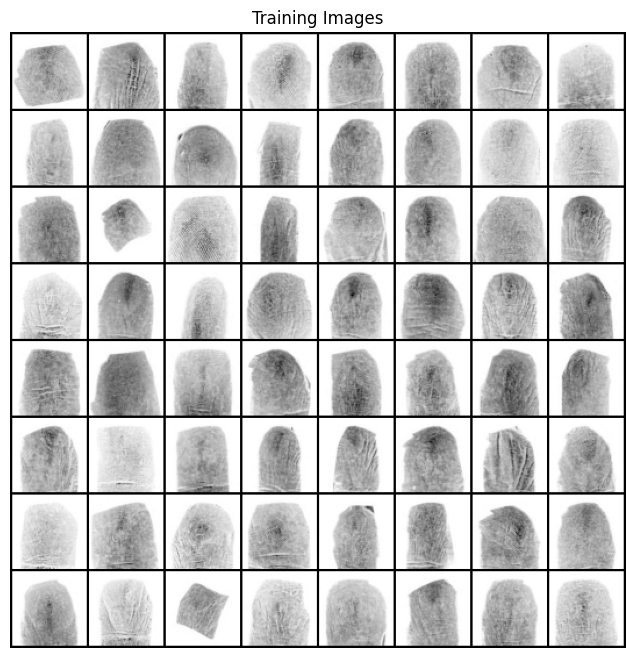

In [20]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64],padding=2,
normalize=True).cpu(),(1,2,0)))
plt.show()

In [21]:
generator = Generator().to(device)
generator.apply(init_weights)
print(generator)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [22]:
discriminator = Discriminator().to(device)
discriminator.apply(init_weights)
print(discriminator)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [23]:
criterion = nn.BCELoss()
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

In [24]:
optimizerD = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG= optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))

In [25]:
img = []
G_loss = []
D_loss = []
iters = 0

In [26]:
# Training loop
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        discriminator.zero_grad()

        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)

        output = discriminator(real_cpu).view(-1)

        errD_real = criterion(output, label.float())
        errD_real.backward()
        D_x = output.mean().item()

        # Batch of random data for the latent space
        noise = torch.randn(b_size, nz, 1, 1, device=device)

        # Generate batch of images
        generated = generator(noise)
        label.fill_(generated_label)

        output = discriminator(generated.detach()).view(-1)

        errD_generated = criterion(output, label.float())
        errD_generated.backward()
        D_G_z1 = output.mean().item()

        errD = errD_real + errD_generated

        optimizerD.step()

        # Btch of random data for the latent space
        noise = torch.randn(b_size, nz, 1, 1, device=device)

        # Generate batch of  images
        generated = generator(noise)

        generator.zero_grad()
        label.fill_(real_label)

        output = discriminator(generated).view(-1)

        errG = criterion(output, label.float())
        errG.backward()
        D_G_z2 = output.mean().item()

        optimizerG.step()

        if i % 25 == 0:
            print('Epoch [%d/%d] Batch [%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'% (epoch, num_epochs, i, len(dataloader), errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        G_loss.append(errG.item())
        D_loss.append(errD.item())

        if (iters % 10 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                generated = generator(fixed_noise).detach().cpu()
            img.append(vutils.make_grid(generated, padding=2, normalize=True))

        iters += 1

im_tens = generated[0]
vutils.save_image(im_tens, f"gen_{iters}.bmp")

Epoch [0/100] Batch [0/16]	Loss_D: 1.4395	Loss_G: 2.5870	D(x): 0.4127	D(G(z)): 0.3082 / 0.1169
Epoch [1/100] Batch [0/16]	Loss_D: 0.0290	Loss_G: 9.1105	D(x): 0.9918	D(G(z)): 0.0186 / 0.0002
Epoch [2/100] Batch [0/16]	Loss_D: 0.0180	Loss_G: 8.3210	D(x): 0.9947	D(G(z)): 0.0123 / 0.0003
Epoch [3/100] Batch [0/16]	Loss_D: 0.0000	Loss_G: 33.3378	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
Epoch [4/100] Batch [0/16]	Loss_D: 0.0298	Loss_G: 15.8212	D(x): 0.9820	D(G(z)): 0.0000 / 0.0000
Epoch [5/100] Batch [0/16]	Loss_D: 2.7245	Loss_G: 14.6518	D(x): 0.9899	D(G(z)): 0.7538 / 0.0000
Epoch [6/100] Batch [0/16]	Loss_D: 1.2303	Loss_G: 5.8069	D(x): 0.9133	D(G(z)): 0.6375 / 0.0043
Epoch [7/100] Batch [0/16]	Loss_D: 1.1877	Loss_G: 3.5717	D(x): 0.6502	D(G(z)): 0.4594 / 0.0415
Epoch [8/100] Batch [0/16]	Loss_D: 1.1603	Loss_G: 0.8908	D(x): 0.4202	D(G(z)): 0.1351 / 0.4423
Epoch [9/100] Batch [0/16]	Loss_D: 1.4935	Loss_G: 5.9243	D(x): 0.8285	D(G(z)): 0.7029 / 0.0034
Epoch [10/100] Batch [0/16]	Loss_D: 1.1143	Loss

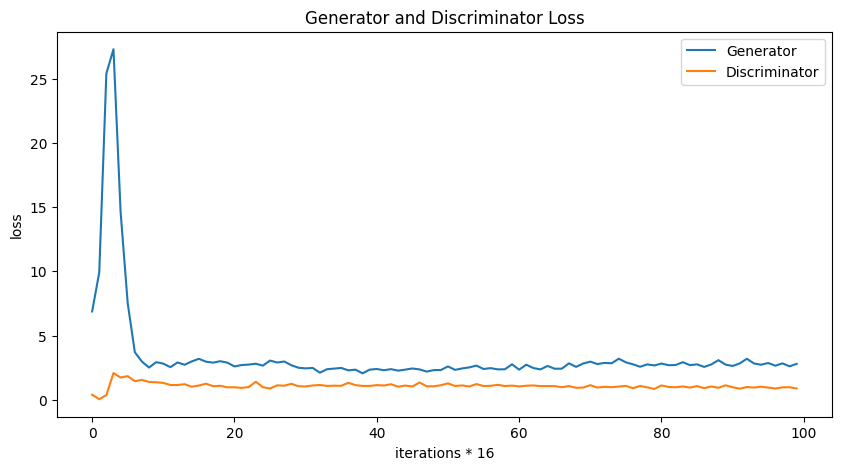

In [27]:
# Plot loss
num_iterations = len(G_loss)
num_plot_points = 100
plot_interval = int(num_iterations / num_plot_points)

avg_G_loss = []
avg_D_loss = []
for i in range(0, num_iterations, plot_interval):
  # Average Loss
  avg_G_loss.append(np.mean(G_loss[i:i+plot_interval]))
  avg_D_loss.append(np.mean(D_loss[i:i+plot_interval]))

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss")
plt.plot(avg_G_loss, label='Generator')
plt.plot(avg_D_loss, label='Discriminator')
plt.xlabel(f'iterations * {plot_interval}')
plt.ylabel('loss')
plt.legend()
plt.show()

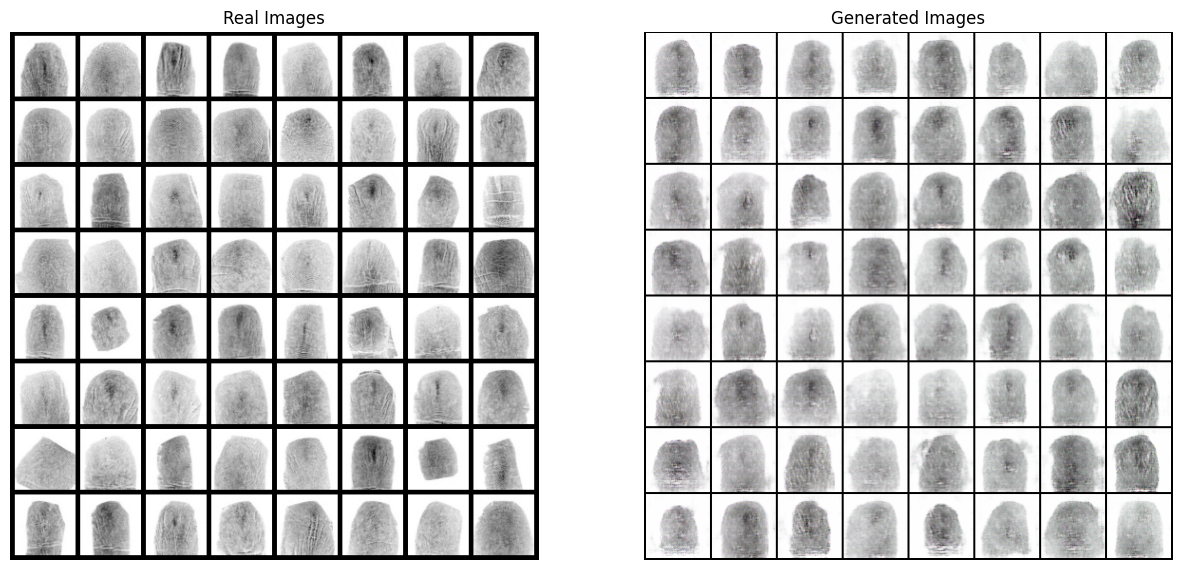

In [28]:
real_batch = next(iter(dataloader))

# Plot real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot generated images
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(img[-1],(1,2,0)))
plt.show()

In [29]:
torch.save(
    {
        'discriminator_state_dict':discriminator.state_dict(),
        'optimizerD_state_dict':optimizerD.state_dict(),
        'generator_state_dict':generator.state_dict(),
        'optimizerG_state_dict':optimizerG.state_dict()
    },
    'networkStates_NIST_Special_Dataset.pyt'
)

In [30]:
output_dir = "Generated_Images_NIST_Special_Dataset"
os.makedirs(output_dir, exist_ok=True)

for i, grid in enumerate(img):
    # Converting the grid
    grid_np = np.transpose(grid.cpu().numpy(), (1, 2, 0)) * 255
    # Converting the numpy array to PIL image
    pil_image = Image.fromarray(grid_np.astype(np.uint8))

    image_path = os.path.join(output_dir, f"generated_image_{i}.bmp")
    pil_image.save(image_path)

    print(f"Saved generated image {i} to {image_path}")

Saved generated image 0 to Generated_Images_NIST_Special_Dataset/generated_image_0.bmp
Saved generated image 1 to Generated_Images_NIST_Special_Dataset/generated_image_1.bmp
Saved generated image 2 to Generated_Images_NIST_Special_Dataset/generated_image_2.bmp
Saved generated image 3 to Generated_Images_NIST_Special_Dataset/generated_image_3.bmp
Saved generated image 4 to Generated_Images_NIST_Special_Dataset/generated_image_4.bmp
Saved generated image 5 to Generated_Images_NIST_Special_Dataset/generated_image_5.bmp
Saved generated image 6 to Generated_Images_NIST_Special_Dataset/generated_image_6.bmp
Saved generated image 7 to Generated_Images_NIST_Special_Dataset/generated_image_7.bmp
Saved generated image 8 to Generated_Images_NIST_Special_Dataset/generated_image_8.bmp
Saved generated image 9 to Generated_Images_NIST_Special_Dataset/generated_image_9.bmp
Saved generated image 10 to Generated_Images_NIST_Special_Dataset/generated_image_10.bmp
Saved generated image 11 to Generated_Ima